In [118]:
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
from source.tserie import TSerie
from source.read_ontario import read_ontario
from source.read_india import read_india
from source.read_brasil import read_brasil
from source.utils import commonWindows
from ccpca import CCPCA

import sys

sys.path.append('/home/texs/Documentos/Repositories/ts2vec')
# from cuml.manifold import UMAP

N_VIZ_SAMPLES = 600
VIS_PATH = 'visualizations'
SMOOTH = 8 # 8 -1 if you don't want to smooth the data otherwise the size of the smooth window
MODE = 'shape' # subsequences - shape
EPOCHS = 40
POLLUTANTS = ['SO2'] # ['NO', 'NOx', 'NO2', 'SO2', 'CO', 'O3', 'PM25']
UMAP_NEIGHBORS = 15

# Months case

In [119]:
windows_map = read_brasil(granularity='months', cache=True)
pollutans = POLLUTANTS
# windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)

In [120]:
windows, dates, station_ids, stations = commonWindows(windows_map, pollutans)
print(windows.shape)

(640, 28, 1)


windows.shape

In [121]:
month_ids = np.array([date.month for date in dates])
year_ids = np.array([date.year for date in dates])


stations_map = {int(i):str(stations[i]) for i in range(len(stations))}
months_map = {int(i):str(i) for i in range(1, 13)}
years_map = {int(year) : str(year) for year in year_ids}

In [122]:
mts = TSerie(X=windows, y = station_ids)

if SMOOTH > 0:
    mts.smooth(window_size=SMOOTH)

if MODE == 'shape':
    mts.shapeNormalizization()
else:
    mts.minMaxNormalizization()


Loaded mts - N: 640, T: 28, D: 1 
(640, 1, 28)


In [2]:
from ts2vec import TS2Vec

# Train a TS2Vec model
model = TS2Vec(
    input_dims=mts.D,
    device=0,
    output_dims=128,
)
loss_log = model.fit(
    mts.X,
    verbose=True,   
)

ModuleNotFoundError: No module named 'ts2vec'

In [124]:
dfeatures = model.encode(mts.X) 
mts.features = model.encode(mts.X, encoding_window='full_series') 


In [125]:
import umap
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_components=2)
# reducer = UMAP(n_components=2)
# reducer = UMAP(n_components=2, n_neighbors=10, min_dist=0.1)
# reducer = TSNE(n_components=2, metric='euclidean')

# coords = reducer.fit_transform(mts.features, y =month_ids)
coords = reducer.fit_transform(mts.features)


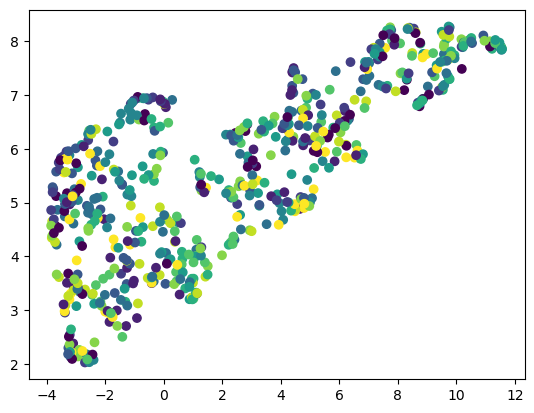

In [126]:
plt.scatter(coords[:, 0], coords[:, 1], c=month_ids)

In [127]:
dfeatures.shape

(640, 28, 128)

In [128]:
# mts.features.min()
from sklearn.decomposition import PCA

tfeatures = np.zeros([mts.N, mts.T])
for i in range(mts.T):
    reducer = PCA(n_components=1)
    tfeatures[:,i] = reducer.fit_transform(dfeatures[:, i, :]).squeeze()


In [129]:
tfeatures.shape

(640, 28)

In [155]:

# np.arange(1, mts.T + 1)

# tfeatures[group_ids == years[mts.T - 4]]

In [157]:
years = np.unique(station_ids)

group_ids = station_ids
fcs = []

for target in years:

    ccpca = CCPCA(n_components=1)
    # target = 2012
    ccpca.fit(
        tfeatures[group_ids==target],
        tfeatures[group_ids!=target],
        var_thres_ratio=0.5,
        n_alphas=40,
        max_log_alpha=0.5,
    )


    coords2 = ccpca.transform(tfeatures[group_ids==target])
    # coords2 = ccpca.transform(dfeatures[year_ids!=2011])
    # coords2 = ccpca.transform(dfeatures)
    best_alpha = ccpca.get_best_alpha()
    cpca_fcs = ccpca.get_feat_contribs()
    fcs.append(cpca_fcs)
    # print(cpca_fcs)
    # print(best_alpha)
    # plt.scatter(coords2[:, 0], coords2[:, 1])
print(len(fcs))
print(fcs[0].shape)


6
(28,)


In [138]:

# print(fcs[item])
# fcs[item].mean(), fcs[item].max(), fcs[item].min()


1999


<BarContainer object of 28 artists>

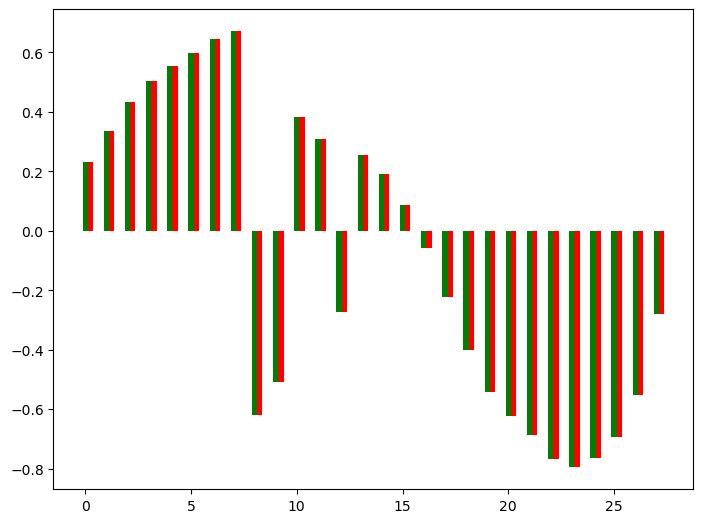

In [163]:
item1 = 2
item2 = 3
print(year_ids[item2])
fcs = np.array(fcs)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.array([i for i in range (28)])
# for i in range(28):
plt.bar(X + 0.00, fcs[item1], color = 'g', width = 0.25)
ax.bar(X + 0.25, fcs[item2], color = 'r', width = 0.25)
# ax.bar(X + 0.50, fcs[:,2], color = 'r', width = 0.25)
# plt.bar(, fcs[:,0])

In [134]:
from server.source.storage import MTSStorage

# storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_months.npy'))    
storage = MTSStorage(os.path.join(VIS_PATH ,'ontario_days.npy'))    
# storage.delete()
storage.load()

dimensions = pollutans
data = np.concatenate([mts.X_orig, mts.X], axis=2) 
storage.add_mts(
    '_'.join(POLLUTANTS) , data , 
    dimensions = dimensions + [dim+ '_norm' for dim in dimensions], 
    labels = {'station': station_ids, 'months': month_ids, 'years': year_ids}, 
    labelsNames={'station': stations_map, 'months': months_map, 'years': years_map}, 
    coords = {
        'coords': coords,
    },
    sampling=True,
    n_samples= N_VIZ_SAMPLES
)

storage.save()

mts shape: N: 640 -  T: 28 - D: 2


!pwd